![alt text](image/python.png "")

# Step 1: Load the Pre-trained Model
We will use MobileNetV3Large, a lightweight neural network trained on ImageNet.
![alt text](image/mobilenet-v3-block.png "")
**The Deep Learning Model is provided by TensorFlow and Keras.**

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large # type: ignore

# Load pre-trained MobileNetV3Large model
model = MobileNetV3Large(weights='imagenet', input_shape=(224, 224, 3))

# Step 2: Define Function that grabs an Image from any GenICam compliant Camera
This function just grabs one image and makes the transfer to 3rd party (numpy)

![alt text](image/numpy.png "")

**CVB is used as acquisition SDK**

In [ ]:
import cvb
import os

def capture_frame(stream):
    
    wait_result = stream.wait()
    composite: cvb.Image = wait_result[0]
    
    return cvb.to_array(composite)

# Step 3: Preprocess the Captured Image
We resize the image to 224x224 pixels and normalize it for the MobileNetV3Large model.

In [ ]:
from PIL import Image
import numpy as np
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input # type: ignore

def preprocess_image(img_array):
    """Ensures image has 3 channels, resizes, and preprocesses for MobileNetV3Large."""
    if len(img_array.shape) == 2:  # Grayscale image
        img_array = np.stack([img_array] * 3, axis=-1)  # Convert to 3-channel RGB
    
    img = Image.fromarray(img_array)
    img = img.resize((224, 224), Image.LANCZOS) # type: ignore
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array, np.array(img).copy()

# Step 4: Make a Prediction Using MobileNetV2
The preprocessed image is passed to the model, and we retrieve the top-3 predictions.

In [ ]:
from tensorflow.keras.applications.mobilenet_v3 import decode_predictions # type: ignore

def predict_image(img_array):
    """Predicts the class of an image using MobileNet_v3."""
    predictions = model.predict(img_array,verbose=0);
    decoded = decode_predictions(predictions, top=3)[0]
    return decoded


# Step 5: Display Results
The original captured image is displayed along with the model's predictions.

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import PIL

def showarray(display, a, fmt='jpeg'):
    clear_output(wait=True)
    display(PIL.Image.fromarray(a))
    
def display_results(display, image_array, predictions):
    """Displays the captured image along with the predictions."""
    showarray(display, image_array)
    print(f"Predictions:\n" + "\n".join([f"{label}: {score:.2f}" for (_, label, score) in predictions]))

# Step 6: Run the Pipeline
Now we capture an image, process it, and display the results.

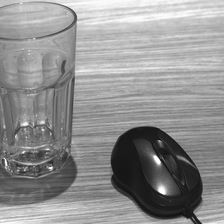

Predictions:
beer_glass: 0.17
water_jug: 0.08
mouse: 0.08
Exiting...


In [20]:
import cvb
import time

display_handle=display(None, display_id=True)
# get the absolute path to the curre
"""Captures a single frame from the CVB device."""
devices = cvb.DeviceFactory.discover_from_root(
    cvb.DiscoverFlags.IgnoreVins|cvb.DiscoverFlags.IncludeMockTL, time_span=30)
if not devices:
    raise RuntimeError("No suitable device found.")

device_token = next(iter(dev.access_token for dev in devices if "DFK" in dev.access_token), None)
if not device_token:
    raise RuntimeError("No Mock device found.")

with cvb.DeviceFactory.open(device_token, cvb.AcquisitionStack.GenTL) as device:
    device: cvb.GenICamDevice = device
    # prepare_device(device)
    stream = device.stream(cvb.ImageStream)
    stream.start()
    print("device started")
    while True:
        try:
            captured_image = capture_frame(stream)
            processed_image, showimage = preprocess_image(captured_image)
            predictions = predict_image(processed_image)
            # Display results
            if showimage is None:
                continue
            display_results(display, showimage, predictions)
            time.sleep(0.01)
        except KeyboardInterrupt:
            print("Exiting...")
            break
        except Exception as e:
            print("error: "+ str (e))
            continue
    stream.stop()
    
        

# Transfer to C++

With CVB in combination with Tensor RT we are able to leverage our external (GPU) memory allocated acquisition and the aligned API for a very simple transfer from Prototype to Production System!


![alt text](image/c++.png "")